# 0. Load Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/favorita-grocery-sales-forecasting/test.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/stores.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/holidays_events.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/transactions.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/train.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/oil.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/sample_submission.csv.7z


In [2]:
!pip install py7zr
import py7zr

     |████████████████████████████████| 63 kB 676 kB/s 
     |████████████████████████████████| 13.7 MB 14.5 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import py7zr
from subprocess import check_output

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        archive = py7zr.SevenZipFile(os.path.join(dirname, filename), mode='r')
        archive.extractall(path="/kaggle/working")
        archive.close()

print(check_output(["ls", "../working"]).decode("utf8"))

__notebook__.ipynb
holidays_events.csv
items.csv
oil.csv
sample_submission.csv
stores.csv
test.csv
train.csv
transactions.csv



In [4]:
df_train = pd.read_csv("../working/train.csv")
df_test = pd.read_csv("../working/test.csv")
df_sub = pd.read_csv("../working/sample_submission.csv")
df_stores = pd.read_csv("../working/stores.csv")
df_items = pd.read_csv("../working/items.csv")
df_trans = pd.read_csv("../working/transactions.csv")
df_oil = pd.read_csv("../working/oil.csv")
df_holiday = pd.read_csv("../working/holidays_events.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Basic EDA

## 1) train.csv

In [5]:
df_train.shape

(125497040, 6)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   item_nbr     int64  
 4   unit_sales   float64
 5   onpromotion  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.6+ GB


In [7]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


In [8]:
df_train.tail()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
125497035,125497035,2017-08-15,54,2089339,4.0,False
125497036,125497036,2017-08-15,54,2106464,1.0,True
125497037,125497037,2017-08-15,54,2110456,192.0,False
125497038,125497038,2017-08-15,54,2113914,198.0,True
125497039,125497039,2017-08-15,54,2116416,2.0,False


In [9]:
train_columns = df_train.columns.tolist()

for i in range(0, len(train_columns)):
    print("***",train_columns[i],"***")
    print(df_train[train_columns[i]].nunique(),'개')
    print(df_train[train_columns[i]].value_counts(normalize=False, sort=True, dropna=False))

*** id ***
125497040 개
121706461    1
86904663     1
36630347     1
65984332     1
61792077     1
            ..
2707562      1
6903915      1
27877484     1
32073837     1
0            1
Name: id, Length: 125497040, dtype: int64
*** date ***
1684 개
2017-07-01    118194
2017-04-01    118122
2017-07-02    117286
2017-05-01    117116
2017-06-04    117074
               ...  
2014-01-01      1911
2016-01-01      1718
2017-01-01      1693
2015-01-01      1176
2013-01-01       578
Name: date, Length: 1684, dtype: int64
*** store_nbr ***
54 개
44    3513089
45    3484244
47    3457407
3     3401264
46    3353890
49    3342531
8     3261184
48    3236523
50    3192566
6     3089799
2     2987840
51    2960031
7     2921204
37    2831691
4     2830554
9     2773790
24    2769889
38    2727731
5     2666691
39    2638036
27    2631714
11    2568282
1     2562153
41    2503919
28    2418816
23    2365697
31    2361724
34    2299422
36    2211162
18    2196682
17    2164020
40    2102799
25    205

## 2) test.csv
- Test data, with the date, store_nbr, item_nbr combinations that are to be predicted, along with the onpromotion information.
- NOTE: The test data has a small number of items that are not contained in the training data. Part of the exercise will be to predict a new item sales based on similar products.
- The public / private leaderboard split is based on time. All items in the public split are also included in the private split.


In [10]:
df_test.shape

(3370464, 5)

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370464 entries, 0 to 3370463
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   id           int64 
 1   date         object
 2   store_nbr    int64 
 3   item_nbr     int64 
 4   onpromotion  bool  
dtypes: bool(1), int64(3), object(1)
memory usage: 106.1+ MB


In [12]:
df_test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [13]:
df_test.tail()

,id,date,store_nbr,item_nbr,onpromotion
3370459,128867499,2017-08-31,54,2132163,False
3370460,128867500,2017-08-31,54,2132318,False
3370461,128867501,2017-08-31,54,2132945,False
3370462,128867502,2017-08-31,54,2132957,False
3370463,128867503,2017-08-31,54,2134244,False


In [14]:
test_columns = df_test.columns.tolist()

for i in range(0, len(test_columns)):
    print("***",test_columns[i],"***")
    print(df_test[test_columns[i]].nunique(),'개')
    print(df_test[test_columns[i]].value_counts(normalize=False, sort=True, dropna=False))

*** id ***
3370464 개
125833214    1
127411792    1
127501924    1
127514210    1
127510112    1
            ..
126700291    1
126704385    1
126003967    1
126008061    1
125829120    1
Name: id, Length: 3370464, dtype: int64
*** date ***
16 개
2017-08-29    210654
2017-08-31    210654
2017-08-27    210654
2017-08-16    210654
2017-08-24    210654
2017-08-25    210654
2017-08-23    210654
2017-08-28    210654
2017-08-18    210654
2017-08-21    210654
2017-08-19    210654
2017-08-17    210654
2017-08-22    210654
2017-08-26    210654
2017-08-20    210654
2017-08-30    210654
Name: date, dtype: int64
*** store_nbr ***
54 개
54    62416
14    62416
25    62416
24    62416
23    62416
22    62416
21    62416
20    62416
19    62416
18    62416
17    62416
16    62416
15    62416
13    62416
53    62416
12    62416
11    62416
10    62416
9     62416
8     62416
7     62416
6     62416
5     62416
4     62416
3     62416
2     62416
26    62416
27    62416
28    62416
29    62416
52    62416


In [15]:
# onpromotion true 데이터 확인

df_test[df_test['onpromotion'] == True ]

,id,date,store_nbr,item_nbr,onpromotion
17,125497057,2017-08-16,1,108701,True
19,125497059,2017-08-16,1,108797,True
28,125497068,2017-08-16,1,114790,True
37,125497077,2017-08-16,1,115891,True
39,125497079,2017-08-16,1,115893,True
...,...,...,...,...,...
3370313,128867353,2017-08-31,54,2060910,True
3370314,128867354,2017-08-31,54,2061025,True
3370326,128867366,2017-08-31,54,2072545,True
3370348,128867388,2017-08-31,54,2087978,True


## 3) sample_submission.csv

In [16]:
df_sub.head()

,id,unit_sales
0,125497040,0
1,125497041,0
2,125497042,0
3,125497043,0
4,125497044,0


## 4) stores.csv
- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.


In [17]:
df_stores.shape

(54, 5)

In [18]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [19]:
df_stores.tail()

,store_nbr,city,state,type,cluster
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


In [20]:
stores_columns = df_stores.columns.tolist()

for i in range(1, len(stores_columns)):
    print("***",stores_columns[i],"***")
    print(df_stores[stores_columns[i]].nunique(),'개')
    print(df_stores[stores_columns[i]].value_counts(normalize=False))


*** city ***
22 개
Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Ambato            2
Machala           2
Salinas           1
Loja              1
Guaranda          1
Playas            1
Ibarra            1
El Carmen         1
Daule             1
Libertad          1
Esmeraldas        1
Riobamba          1
Puyo              1
Quevedo           1
Babahoyo          1
Cayambe           1
Name: city, dtype: int64
*** state ***
16 개
Pichincha                         19
Guayas                            11
Manabi                             3
Azuay                              3
Santo Domingo de los Tsachilas     3
Tungurahua                         2
El Oro                             2
Cotopaxi                           2
Los Rios                           2
Imbabura                           1
Bolivar                            1
Chimborazo                         1
Esmeraldas                         1
Santa Elena      

In [21]:
df_stores['city'].nunique()

22

## 5) items.csv

- Item metadata, including family, class, and perishable.
- NOTE: Items marked as perishable have a score weight of 1.25; otherwise, the weight is 1.0.



In [22]:
df_items.shape

(4100, 4)

In [23]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int64 
 1   family      4100 non-null   object
 2   class       4100 non-null   int64 
 3   perishable  4100 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 128.2+ KB


In [24]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [25]:
df_items.tail()

,item_nbr,family,class,perishable
4095,2132318,GROCERY I,1002,0
4096,2132945,GROCERY I,1026,0
4097,2132957,GROCERY I,1068,0
4098,2134058,BEVERAGES,1124,0
4099,2134244,"LIQUOR,WINE,BEER",1364,0


In [26]:
item_columns = df_items.columns.tolist()

for i in range(0, len(item_columns)):
    print("***",item_columns[i],"***")
    print(df_items[item_columns[i]].nunique(),'개')
    print(df_items[item_columns[i]].value_counts(normalize=False))

*** item_nbr ***
4100 개
1977997    1
852934     1
1950405    1
1239748    1
1033395    1
          ..
2131010    1
740723     1
1459058    1
1660272    1
174081     1
Name: item_nbr, Length: 4100, dtype: int64
*** family ***
33 개
GROCERY I                     1334
BEVERAGES                      613
CLEANING                       446
PRODUCE                        306
DAIRY                          242
PERSONAL CARE                  153
BREAD/BAKERY                   134
HOME CARE                      108
DELI                            91
MEATS                           84
HOME AND KITCHEN I              77
LIQUOR,WINE,BEER                73
FROZEN FOODS                    55
POULTRY                         54
HOME AND KITCHEN II             45
EGGS                            41
CELEBRATION                     31
PREPARED FOODS                  26
LAWN AND GARDEN                 26
LADIESWEAR                      21
LINGERIE                        20
AUTOMOTIVE                      20


In [27]:
# perishable 제품에 주로 어던 카테고리가 속하는지 확인

df_items[df_items['perishable'] == 1]['family'].value_counts(normalize=False)

PRODUCE           306
DAIRY             242
BREAD/BAKERY      134
DELI               91
MEATS              84
POULTRY            54
EGGS               41
PREPARED FOODS     26
SEAFOOD             8
Name: family, dtype: int64

## 6) transactions.csv

- The count of sales transactions for each date, store_nbr combination. Only included for the training data timeframe.



In [28]:
df_trans.shape

(83488, 3)

In [29]:
df_trans.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [30]:
df_trans.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [31]:
df_trans['transactions'].describe()

count    83488.000000
mean      1694.602158
std        963.286644
min          5.000000
25%       1046.000000
50%       1393.000000
75%       2079.000000
max       8359.000000
Name: transactions, dtype: float64

In [32]:
trans_columns = df_trans.columns.tolist()

for i in range(0, len(trans_columns)):
    print("***",trans_columns[i],"***")
    print(df_trans[trans_columns[i]].nunique(),'개')
    print(df_trans[trans_columns[i]].value_counts(normalize=False))

*** date ***
1682 개
2017-06-21    54
2017-04-21    54
2017-06-05    54
2017-07-16    54
2017-08-02    54
              ..
2016-01-04    14
2014-01-01     2
2015-01-01     1
2017-01-01     1
2013-01-01     1
Name: date, Length: 1682, dtype: int64
*** store_nbr ***
54 개
38    1678
26    1678
31    1678
33    1678
34    1678
37    1678
39    1678
41    1677
23    1677
28    1677
32    1677
5     1677
40    1677
27    1677
49    1677
47    1677
2     1677
51    1677
50    1677
48    1677
16    1677
46    1677
45    1677
44    1677
6     1676
3     1676
8     1676
9     1676
11    1676
13    1676
15    1676
19    1676
4     1676
54    1676
1     1676
35    1676
7     1675
10    1675
17    1674
43    1672
30    1655
14    1638
12    1616
25    1615
24    1577
18    1566
36    1551
53    1167
20     909
29     874
21     748
42     720
22     671
52     118
Name: store_nbr, dtype: int64
*** transactions ***
4993 개
1207    90
1200    86
1304    81
1296    80
1282    80
        ..
5380     1
57

## 7) oil.csv

- Daily oil price. Includes values during both the train and test data timeframe. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)



In [33]:
df_oil.shape

(1218, 2)

In [34]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [35]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [36]:
df_oil.tail()

,date,dcoilwtico
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96
1217,2017-08-31,47.26


In [37]:
oil_columns = df_oil.columns.tolist()

for i in range(0, len(oil_columns)):
    print("***",oil_columns[i],"***")
    print(df_oil[oil_columns[i]].nunique(),'개')
    print(df_oil[oil_columns[i]].value_counts(normalize=False, sort=True, dropna=False))

*** date ***
1218 개
2013-03-01    1
2013-06-03    1
2013-06-24    1
2014-12-26    1
2017-02-14    1
             ..
2014-08-07    1
2016-04-14    1
2014-11-24    1
2013-09-02    1
2016-06-02    1
Name: date, Length: 1218, dtype: int64
*** dcoilwtico ***
998 개
NaN      43
46.02     4
93.12     4
96.44     4
60.01     4
         ..
48.27     1
41.74     1
48.90     1
45.86     1
33.66     1
Name: dcoilwtico, Length: 999, dtype: int64


In [38]:
# NaN값이 있는 일자 확인

df_oil[df_oil['dcoilwtico'] == 'NaN']
# null_value = df_oil.loc[[0],['dcoilwtico']].to_string
# null_value

,date,dcoilwtico


## 8) holidays_events.csv
- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).


In [39]:
df_holiday.shape

(350, 6)

In [40]:
df_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [41]:
df_holiday.head(50)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [42]:
df_holiday.tail()

,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [43]:
df_holiday[df_holiday['type'] == 'Bridge']

,date,type,locale,locale_name,description,transferred
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False
156,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False
160,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano,False
277,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False


In [44]:
df_holiday[df_holiday['type'] == 'Work Day']

,date,type,locale,locale_name,description,transferred
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
149,2014-12-20,Work Day,National,Ecuador,Recupero Puente Navidad,False
161,2015-01-10,Work Day,National,Ecuador,Recupero Puente Primer dia del ano,False
283,2016-11-12,Work Day,National,Ecuador,Recupero Puente Dia de Difuntos,False


In [45]:
holiday_columns = df_holiday.columns.tolist()

for i in range(0, len(holiday_columns)):
    print("***",holiday_columns[i],"***")
    print(df_holiday[holiday_columns[i]].nunique(),'개')
    print(df_holiday[holiday_columns[i]].value_counts(normalize=False, sort=True, dropna=False))

*** date ***
312 개
2014-06-25    4
2017-06-25    3
2013-06-25    3
2015-06-25    3
2016-06-25    3
             ..
2016-05-06    1
2016-05-15    1
2014-07-04    1
2012-08-24    1
2012-11-03    1
Name: date, Length: 312, dtype: int64
*** type ***
6 개
Holiday       221
Event          56
Additional     51
Transfer       12
Work Day        5
Bridge          5
Name: type, dtype: int64
*** locale ***
3 개
National    174
Local       152
Regional     24
Name: locale, dtype: int64
*** locale_name ***
24 개
Ecuador                           174
Quito                              13
Riobamba                           12
Guaranda                           12
Ambato                             12
Latacunga                          12
Guayaquil                          11
Ibarra                              7
Cuenca                              7
Quevedo                             6
Machala                             6
Santa Elena                         6
Cayambe                             6
Puyo

# Basic Visualization

In [46]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

## 1) stores

In [47]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


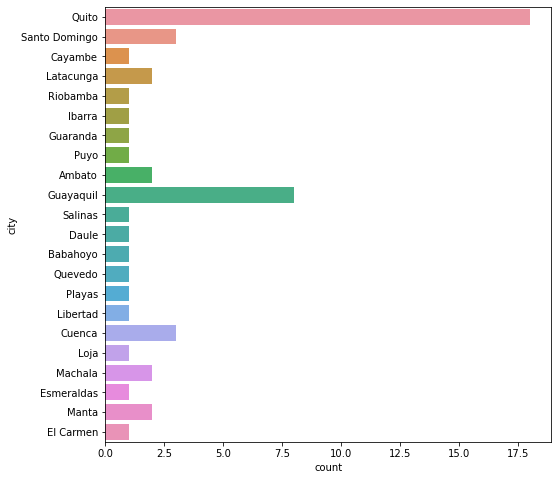

In [48]:
# Stores distribution across cities

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=df_stores['city'], data=df_stores) 

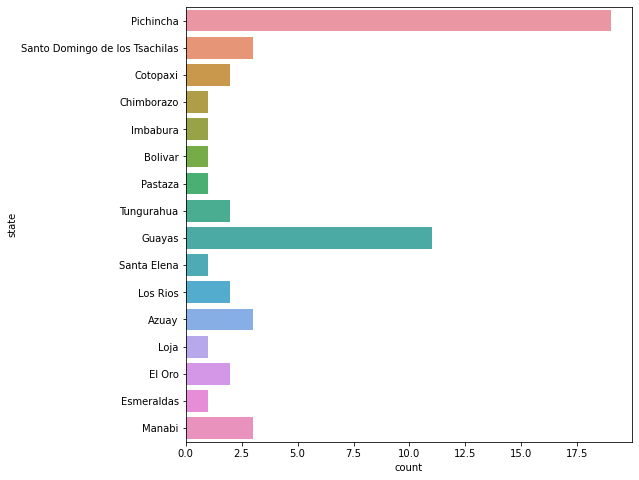

In [49]:
# Stores distribution across states

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=df_stores['state'], data=df_stores) 

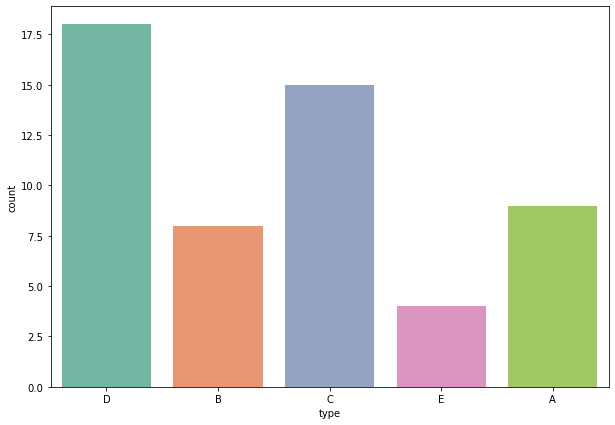

In [50]:
# Different types of stores

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax = sns.countplot(x="type", data=df_stores, palette="Set2")

In [51]:
# Types of stores across cities

ct = pd.crosstab(df_stores.city, df_stores.type)
ct

type,A,B,C,D,E
city,,,,,
Ambato,1,0,0,1,0
Babahoyo,0,1,0,0,0
Cayambe,0,1,0,0,0
Cuenca,0,1,0,2,0
Daule,0,0,0,1,0
El Carmen,0,0,1,0,0
Esmeraldas,0,0,0,0,1
Guaranda,0,0,1,0,0
Guayaquil,1,1,2,2,2


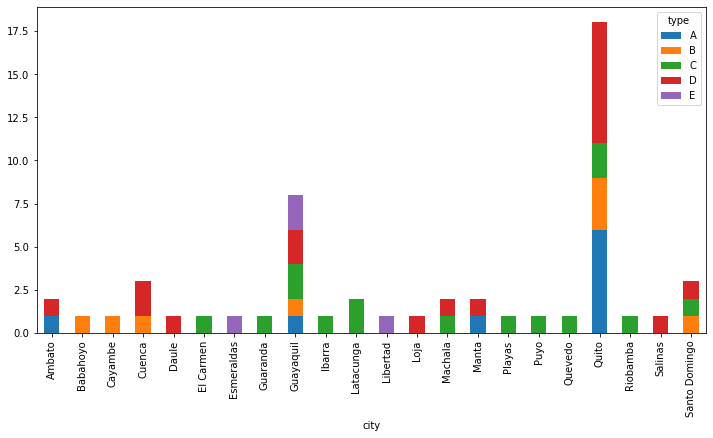

In [52]:
ct.plot.bar(figsize = (12, 6), stacked=True)
plt.legend(title = 'type')

plt.show()

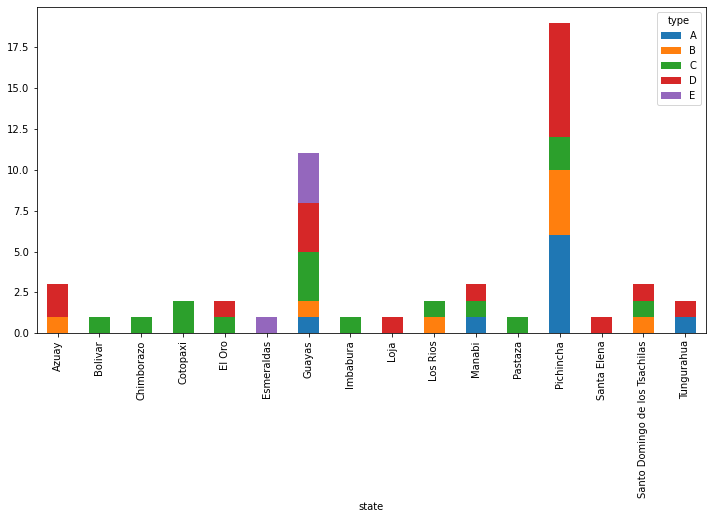

In [53]:
# Types of stores across states

ct = pd.crosstab(df_stores.state, df_stores.type)

ct.plot.bar(figsize = (12, 6), stacked=True)
plt.legend(title = 'type')

plt.show()

In [54]:
df_stores.sort_values(by=['state'])

,store_nbr,city,state,type,cluster
41,42,Cuenca,Azuay,D,2
38,39,Cuenca,Azuay,B,6
36,37,Cuenca,Azuay,D,2
18,19,Guaranda,Bolivar,C,15
13,14,Riobamba,Chimborazo,C,7
12,13,Latacunga,Cotopaxi,C,15
11,12,Latacunga,Cotopaxi,C,15
40,41,Machala,El Oro,D,4
39,40,Machala,El Oro,C,3
42,43,Esmeraldas,Esmeraldas,E,10


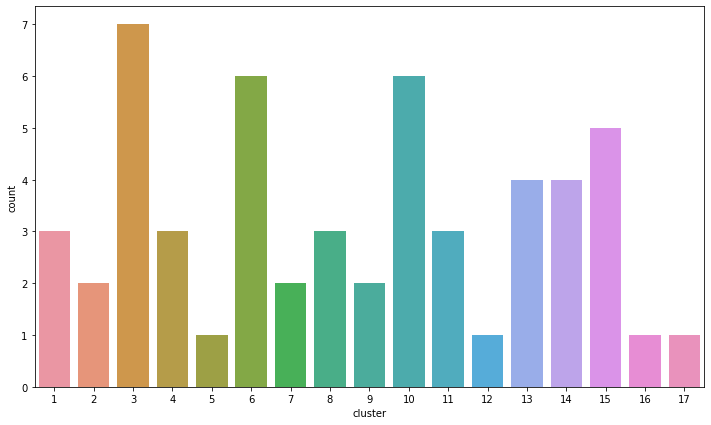

In [55]:
# Distribution of different clusters

fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
ax = sns.countplot(x="cluster", data=df_stores)

In [56]:
# Types against clusters

plt.style.use('seaborn-white')

type_cluster = df_stores.groupby(['type','cluster']).size()
type_cluster
# diffrence between .size() vs .count()
# => size includes NaN values, count does not:

type  cluster
A     5          1
      11         3
      14         4
      17         1
B     6          6
      10         1
      16         1
C     3          7
      7          2
      12         1
      15         5
D     1          3
      2          2
      4          3
      8          3
      9          2
      10         1
      13         4
E     10         4
dtype: int64

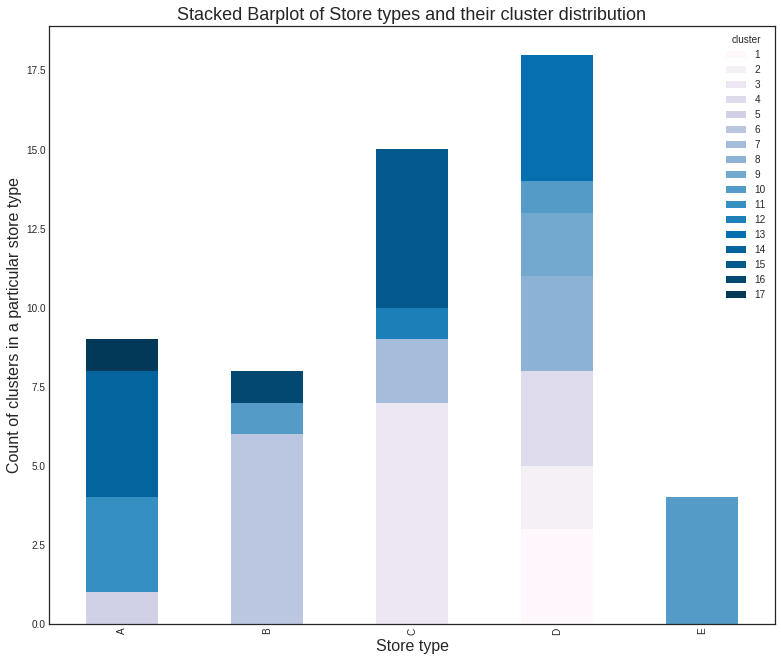

In [57]:
type_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'PuBu', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store types and their cluster distribution', fontsize=18)
plt.ylabel('Count of clusters in a particular store type', fontsize=16)
plt.xlabel('Store type', fontsize=16)
plt.show()

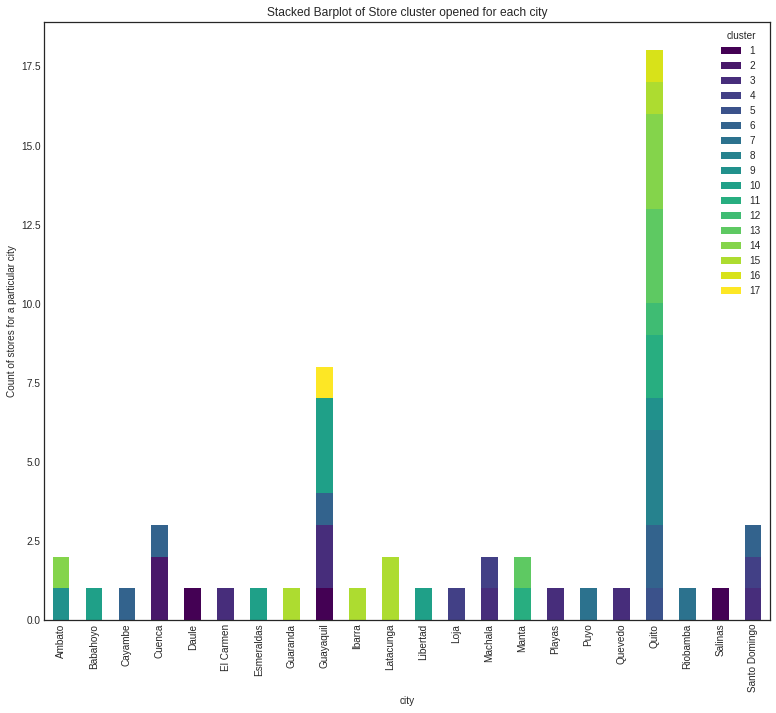

In [58]:
# cluster of stores across the different cities

plt.style.use('seaborn-white')
city_cluster = df_stores.groupby(['city','cluster']).store_nbr.size()
city_cluster.unstack().plot(kind='bar',stacked=True, colormap= 'viridis', figsize=(13,11),  grid=False)
plt.title('Stacked Barplot of Store cluster opened for each city')
plt.ylabel('Count of stores for a particular city')
plt.show()

## 2) items

In [59]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


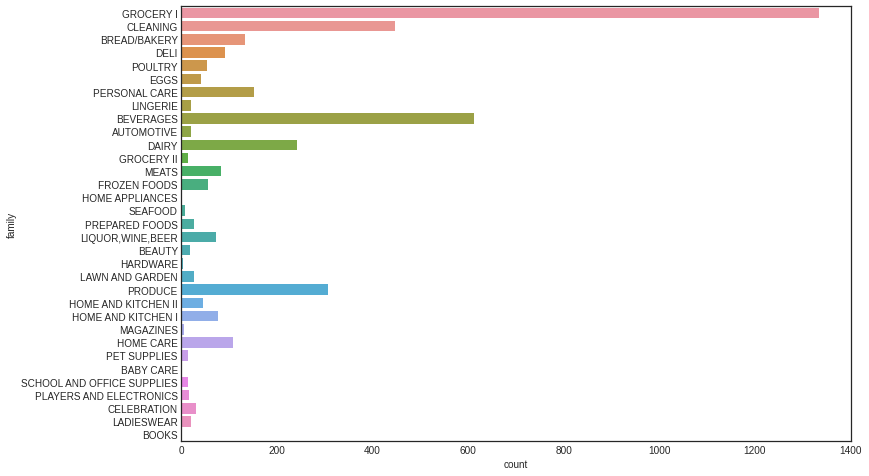

In [60]:
# Distribution of various families of items

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.countplot(y = "family", data = df_items)

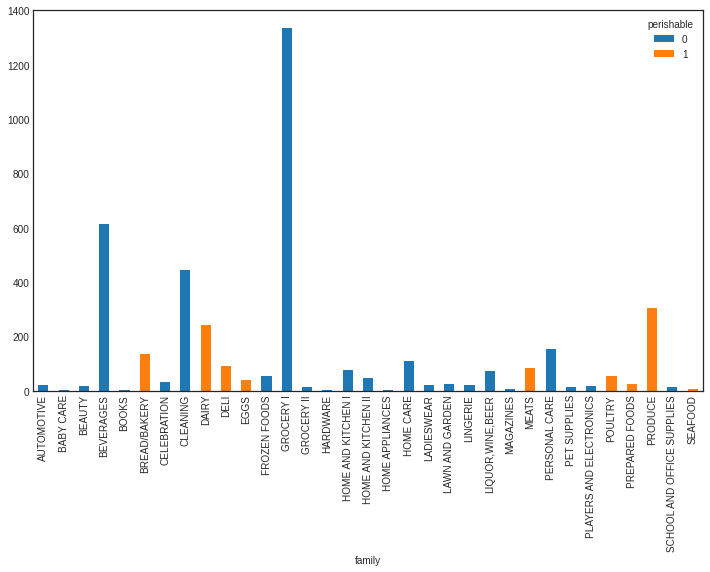

In [61]:
# Distribution of perishable goods by family

ct = pd.crosstab(df_items.family, df_items.perishable)
ct.plot.bar(figsize = (12, 7), stacked=True)
plt.legend(title='perishable')
plt.show()

In [62]:
# Distrbution of number of unique classes per family of items.

xc = df_items.groupby(['family'])['class'].nunique()
xc

family
AUTOMOTIVE                     5
BABY CARE                      1
BEAUTY                         9
BEVERAGES                     21
BOOKS                          1
BREAD/BAKERY                  15
CELEBRATION                    4
CLEANING                      26
DAIRY                         22
DELI                          13
EGGS                           3
FROZEN FOODS                  11
GROCERY I                     67
GROCERY II                     1
HARDWARE                       1
HOME AND KITCHEN I            20
HOME AND KITCHEN II           12
HOME APPLIANCES                1
HOME CARE                      6
LADIESWEAR                     1
LAWN AND GARDEN                7
LINGERIE                       3
LIQUOR,WINE,BEER              19
MAGAZINES                      4
MEATS                          5
PERSONAL CARE                 13
PET SUPPLIES                   2
PLAYERS AND ELECTRONICS        1
POULTRY                        3
PREPARED FOODS                10
PRO

In [63]:
xc2 = df_items.groupby(['family'])['class'].size()
xc2

family
AUTOMOTIVE                      20
BABY CARE                        1
BEAUTY                          19
BEVERAGES                      613
BOOKS                            1
BREAD/BAKERY                   134
CELEBRATION                     31
CLEANING                       446
DAIRY                          242
DELI                            91
EGGS                            41
FROZEN FOODS                    55
GROCERY I                     1334
GROCERY II                      14
HARDWARE                         4
HOME AND KITCHEN I              77
HOME AND KITCHEN II             45
HOME APPLIANCES                  1
HOME CARE                      108
LADIESWEAR                      21
LAWN AND GARDEN                 26
LINGERIE                        20
LIQUOR,WINE,BEER                73
MAGAZINES                        6
MEATS                           84
PERSONAL CARE                  153
PET SUPPLIES                    14
PLAYERS AND ELECTRONICS         17
POULTRY      

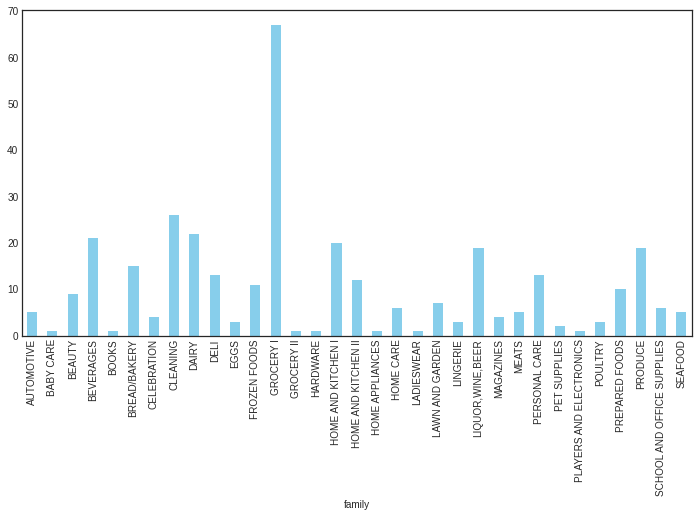

In [64]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
xc.plot.bar(color='skyblue')
plt.show()

## 3) transactions

In [65]:
df_trans.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '19'),
 Text(0, 0, '20'),
 Text(0, 0, '21'),
 Text(0, 0, '22'),
 Text(0, 0, '23'),
 Text(0, 0, '24'),
 Text(0, 0, '25'),
 Text(0, 0, '26'),
 Text(0, 0, '27'),
 Text(0, 0, '28'),
 Text(0, 0, '29'),
 Text(0, 0, '30'),
 Text(0, 0, '31'),
 Text(0, 0, '32'),
 Text(0, 0, '33'),
 Text(0, 0, '34'),
 Text(0, 0, '35'),
 Text(0, 0, '36'),
 Text(0, 0, '37'),
 Text(0, 0, '38'),
 Text(0, 0, '39'),
 Text(0, 0, '40'),
 Text(0, 0, '41'),
 Text(0, 0, '42'),
 Text(0, 0, '43'),
 Text(0, 0, '44'),
 Text(0, 0, '45'),
 Text(0, 0, '46'),
 Text(0, 0, '47'),
 Text(0, 0, '48'),
 Text(0, 0, '49'),
 Text(0, 0, '50'),
 Text(0, 0, '51'),
 Text(0, 0, '52'),
 Text(0, 0, '53'),
 T

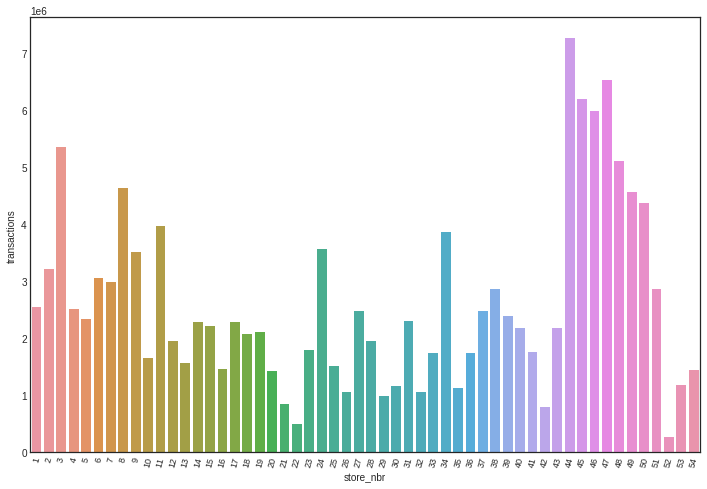

In [66]:
# 스토어별 총 업무량 규모

amount = (df_trans.groupby(['store_nbr']).sum())
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.barplot(x = amount.index, y= "transactions", data = amount)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 75, fontsize = 9)

In [67]:
amount_trans = pd.merge(amount, df_stores, left_on='store_nbr', right_on='store_nbr', how='left')
amount_trans.sort_values(by=['transactions'], ascending=False)

,store_nbr,transactions,city,state,type,cluster
43,44,7273093,Quito,Pichincha,A,5
46,47,6535810,Quito,Pichincha,A,14
44,45,6201115,Quito,Pichincha,A,11
45,46,5990113,Quito,Pichincha,A,14
2,3,5366350,Quito,Pichincha,D,8
47,48,5107785,Quito,Pichincha,A,14
7,8,4637971,Quito,Pichincha,D,8
48,49,4574103,Quito,Pichincha,A,11
49,50,4384444,Ambato,Tungurahua,A,14
10,11,3972488,Cayambe,Pichincha,B,6


[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '19'),
 Text(0, 0, '20'),
 Text(0, 0, '21'),
 Text(0, 0, '22'),
 Text(0, 0, '23'),
 Text(0, 0, '24'),
 Text(0, 0, '25'),
 Text(0, 0, '26'),
 Text(0, 0, '27'),
 Text(0, 0, '28'),
 Text(0, 0, '29'),
 Text(0, 0, '30'),
 Text(0, 0, '31'),
 Text(0, 0, '32'),
 Text(0, 0, '33'),
 Text(0, 0, '34'),
 Text(0, 0, '35'),
 Text(0, 0, '36'),
 Text(0, 0, '37'),
 Text(0, 0, '38'),
 Text(0, 0, '39'),
 Text(0, 0, '40'),
 Text(0, 0, '41'),
 Text(0, 0, '42'),
 Text(0, 0, '43'),
 Text(0, 0, '44'),
 Text(0, 0, '45'),
 Text(0, 0, '46'),
 Text(0, 0, '47'),
 Text(0, 0, '48'),
 Text(0, 0, '49'),
 Text(0, 0, '50'),
 Text(0, 0, '51'),
 Text(0, 0, '52'),
 Text(0, 0, '53'),
 T

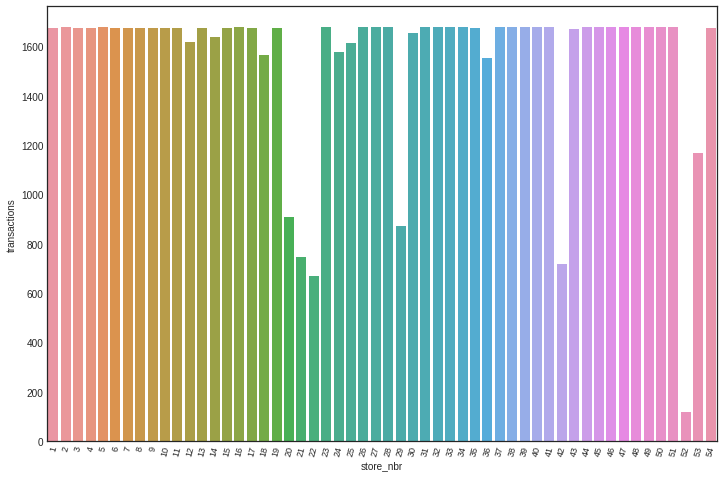

In [68]:
# 스토어별 총 업무량 회수

number = (df_trans.groupby(['store_nbr']).count())
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.barplot(x = number.index, y= "transactions", data = number)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 75, fontsize = 9)

In [69]:
number_trans= pd.merge(number, df_stores, left_on='store_nbr', right_on='store_nbr', how='left')
number_trans.sort_values(by=['transactions'])

,store_nbr,date,transactions,city,state,type,cluster
51,52,118,118,Manta,Manabi,A,11
21,22,671,671,Puyo,Pastaza,C,7
41,42,720,720,Cuenca,Azuay,D,2
20,21,748,748,Santo Domingo,Santo Domingo de los Tsachilas,B,6
28,29,874,874,Guayaquil,Guayas,E,10
19,20,909,909,Quito,Pichincha,B,6
52,53,1167,1167,Manta,Manabi,D,13
35,36,1551,1551,Libertad,Guayas,E,10
17,18,1566,1566,Quito,Pichincha,B,16
23,24,1577,1577,Guayaquil,Guayas,D,1


[Text(0, 0, '2013-01-01'),
 Text(0, 0, '2013-01-02'),
 Text(0, 0, '2013-01-03'),
 Text(0, 0, '2013-01-04'),
 Text(0, 0, '2013-01-05'),
 Text(0, 0, '2013-01-06'),
 Text(0, 0, '2013-01-07'),
 Text(0, 0, '2013-01-08'),
 Text(0, 0, '2013-01-09'),
 Text(0, 0, '2013-01-10'),
 Text(0, 0, '2013-01-11'),
 Text(0, 0, '2013-01-12'),
 Text(0, 0, '2013-01-13'),
 Text(0, 0, '2013-01-14'),
 Text(0, 0, '2013-01-15'),
 Text(0, 0, '2013-01-16'),
 Text(0, 0, '2013-01-17'),
 Text(0, 0, '2013-01-18'),
 Text(0, 0, '2013-01-19'),
 Text(0, 0, '2013-01-20'),
 Text(0, 0, '2013-01-21'),
 Text(0, 0, '2013-01-22'),
 Text(0, 0, '2013-01-23'),
 Text(0, 0, '2013-01-24'),
 Text(0, 0, '2013-01-25'),
 Text(0, 0, '2013-01-26'),
 Text(0, 0, '2013-01-27'),
 Text(0, 0, '2013-01-28'),
 Text(0, 0, '2013-01-29'),
 Text(0, 0, '2013-01-30'),
 Text(0, 0, '2013-01-31'),
 Text(0, 0, '2013-02-01'),
 Text(0, 0, '2013-02-02'),
 Text(0, 0, '2013-02-03'),
 Text(0, 0, '2013-02-04'),
 Text(0, 0, '2013-02-05'),
 Text(0, 0, '2013-02-06'),
 

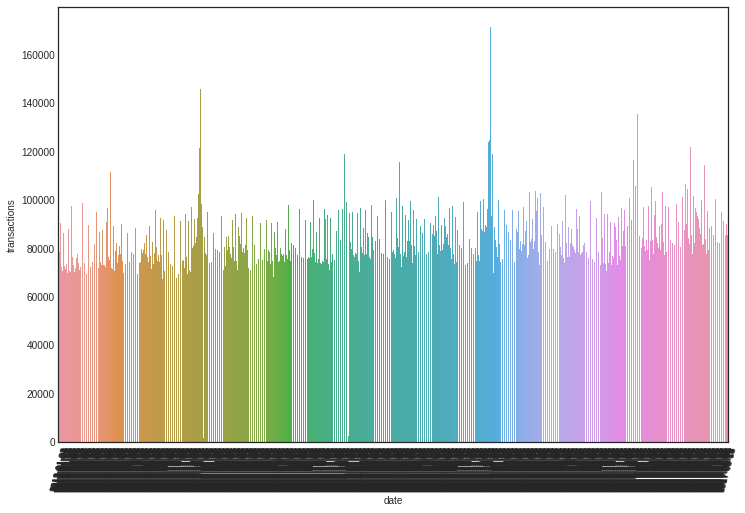

In [70]:
# 일자별 총 업무량 규모

amount_date = (df_trans.groupby(['date']).sum())
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.barplot(x = amount_date.index, y= "transactions", data = amount_date)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 75, fontsize = 9)

In [71]:
amount_date

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1210,93215
2013-01-03,1210,78504
2013-01-04,1210,78494
2013-01-05,1210,93573
...,...,...
2017-08-11,1485,89551
2017-08-12,1485,89927
2017-08-13,1485,85993


In [72]:
# 일자정보 연/월/일로 나누기

re_trans = df_trans.copy()
dates = re_trans['date'].str.split('-')
print(dates)

0        [2013, 01, 01]
1        [2013, 01, 02]
2        [2013, 01, 02]
3        [2013, 01, 02]
4        [2013, 01, 02]
              ...      
83483    [2017, 08, 15]
83484    [2017, 08, 15]
83485    [2017, 08, 15]
83486    [2017, 08, 15]
83487    [2017, 08, 15]
Name: date, Length: 83488, dtype: object


In [73]:
re_trans['year'] = dates.str.get(0)
re_trans['month'] = dates.str.get(1)
re_trans['day'] = dates.str.get(2)
# re_trans.drop('date',inplace=True, axis=1)
re_trans = re_trans[['year','month','day','store_nbr','transactions']]
re_trans

,year,month,day,store_nbr,transactions
0,2013,01,01,25,770
1,2013,01,02,1,2111
2,2013,01,02,2,2358
3,2013,01,02,3,3487
4,2013,01,02,4,1922
...,...,...,...,...,...
83483,2017,08,15,50,2804
83484,2017,08,15,51,1573
83485,2017,08,15,52,2255
83486,2017,08,15,53,932


In [74]:
# 일일 업무량이 가장 큰 데이터
df_trans[df_trans['transactions'] == df_trans['transactions'].max()]

,date,store_nbr,transactions
52011,2015-12-23,44,8359


In [75]:
# transactions양이 가장 많은 날(top 100)
top_trans = df_trans.nlargest(100, 'transactions')
print(top_trans.date.unique())

['2015-12-23' '2016-12-23' '2013-12-23' '2014-12-23' '2013-12-24'
 '2015-12-24' '2014-12-24' '2016-12-21' '2016-12-24' '2014-12-22'
 '2015-12-22' '2016-12-22' '2014-12-21' '2013-12-22' '2015-12-19'
 '2014-12-20' '2015-12-21' '2013-12-21' '2015-12-20' '2015-05-09'
 '2016-12-18' '2013-12-30' '2017-05-13' '2016-12-17' '2016-12-30'
 '2013-05-11' '2014-05-10' '2014-12-13' '2016-12-20' '2014-06-14'
 '2016-05-07' '2013-12-15' '2013-12-20' '2014-09-07' '2013-12-18'
 '2014-06-01' '2013-12-19']


In [76]:
# 일잂 업무량이 가장 작은 데이터
df_trans[df_trans['transactions'] == df_trans['transactions'].min()]

,date,store_nbr,transactions
65479,2016-09-07,43,5


In [77]:
# transactions양이 가장 적은 날(top 100)
lower_transe = df_trans.sort_values('transactions', ascending=True).head(100)
print(lower_transe.date.unique())

['2016-09-07' '2016-01-02' '2016-01-04' '2016-04-17' '2016-04-18'
 '2017-02-20' '2016-05-18' '2014-07-11' '2017-04-03' '2014-03-02'
 '2013-07-29' '2016-02-08' '2016-02-09' '2017-03-06' '2015-05-14'
 '2016-10-25' '2015-11-01' '2015-08-20' '2013-02-10' '2015-08-09'
 '2015-02-15' '2016-09-27' '2017-02-26' '2015-11-10' '2016-09-22'
 '2017-02-27' '2016-10-26' '2017-02-09' '2017-05-25' '2016-09-29'
 '2016-09-08' '2013-06-26' '2015-12-27' '2016-07-12' '2013-02-11'
 '2016-01-19' '2016-03-27' '2014-12-28' '2017-04-08' '2013-02-17'
 '2016-09-14' '2014-03-03' '2016-10-18' '2016-03-25' '2016-02-07'
 '2016-07-28' '2016-09-28' '2016-10-20' '2016-09-13' '2016-09-26'
 '2016-08-11' '2016-07-21' '2016-04-28' '2016-03-22' '2016-07-13'
 '2016-05-19' '2014-11-02' '2016-02-21' '2016-09-20' '2016-04-27'
 '2017-06-27' '2013-05-22' '2015-02-26' '2016-06-28' '2016-08-13'
 '2016-06-27' '2013-05-26' '2013-11-27' '2017-03-30' '2016-03-26'
 '2016-09-12' '2015-01-29' '2017-01-30' '2014-04-20' '2016-07-26'
 '2013-06-

[Text(0, 0, '2013'),
 Text(0, 0, '2014'),
 Text(0, 0, '2015'),
 Text(0, 0, '2016'),
 Text(0, 0, '2017')]

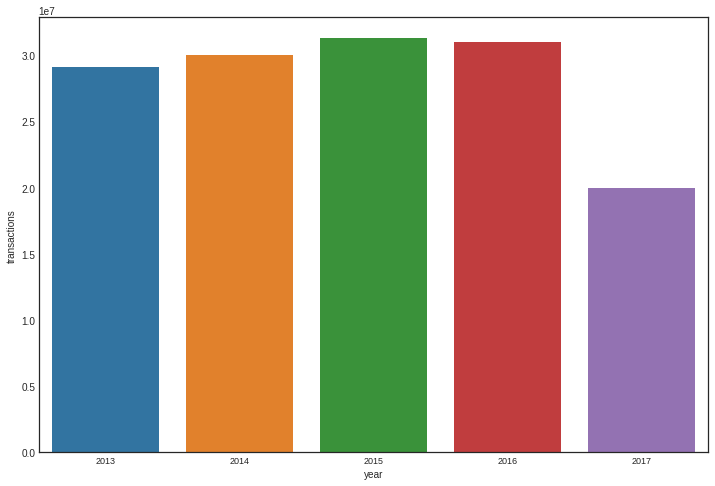

In [78]:
# 연도별 총 거래량 변화

year_amount = (re_trans.groupby(['year']).sum())
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.barplot(x = year_amount.index, y= "transactions", data = year_amount)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 9)

In [79]:
year_amount[['transactions']]

,transactions
year,
2013,29107173
2014,30006929
2015,31312370
2016,31052337
2017,20000136


In [80]:
re_trans

,year,month,day,store_nbr,transactions
0,2013,01,01,25,770
1,2013,01,02,1,2111
2,2013,01,02,2,2358
3,2013,01,02,3,3487
4,2013,01,02,4,1922
...,...,...,...,...,...
83483,2017,08,15,50,2804
83484,2017,08,15,51,1573
83485,2017,08,15,52,2255
83486,2017,08,15,53,932


In [81]:
# 각 월별 업무량 변화 추이 (x= year / hue = month)

## 4) oil

In [82]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


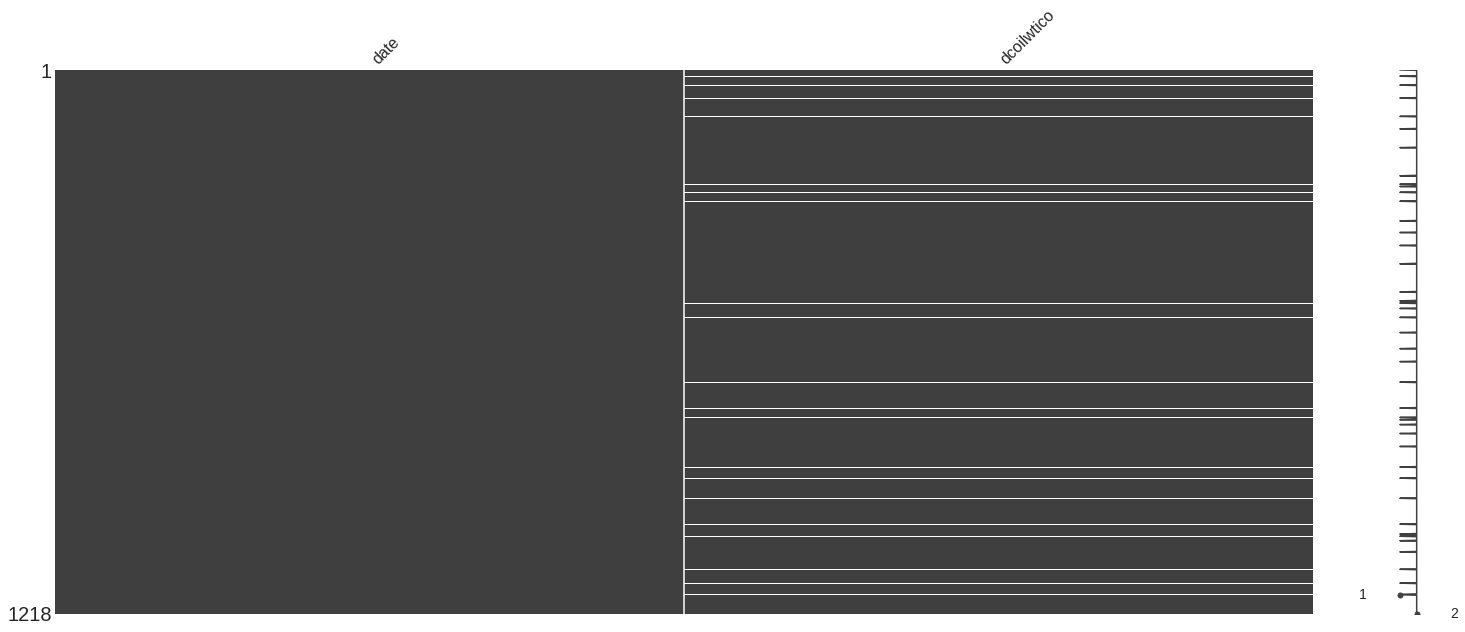

In [83]:
# missingno 라이브러리 활용하여 null값 확인

import missingno as msno

msno.matrix(df_oil)

In [84]:
# oil 가격 최대치 일자 확인
df_oil[df_oil['dcoilwtico'] == df_oil['dcoilwtico'].max()]

,date,dcoilwtico
178,2013-09-06,110.62


In [85]:
# oil 가격 최소치 일자 확인
df_oil[df_oil['dcoilwtico'] == df_oil['dcoilwtico'].min()]

,date,dcoilwtico
812,2016-02-11,26.19


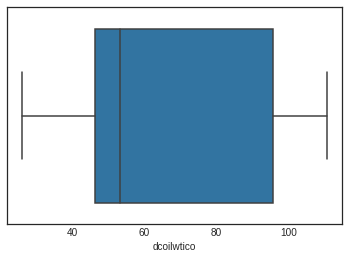

In [86]:
# ax = sns.boxplot(x=df_oil["dcoilwtico"])
sns.boxplot(x = "dcoilwtico",  data = df_oil)
plt.show()

In [87]:
df_oil['dcoilwtico'].describe()

count    1175.000000
mean       67.714366
std        25.630476
min        26.190000
25%        46.405000
50%        53.190000
75%        95.660000
max       110.620000
Name: dcoilwtico, dtype: float64

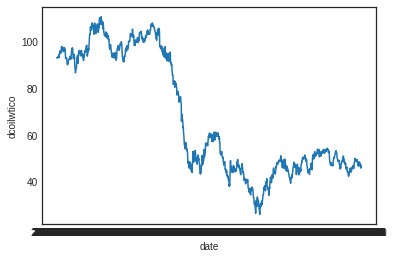

In [88]:
# 오일가격의 변화추이
sns.lineplot(data=df_oil, x="date", y="dcoilwtico")

## 5) holidays_events

In [89]:
df_holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


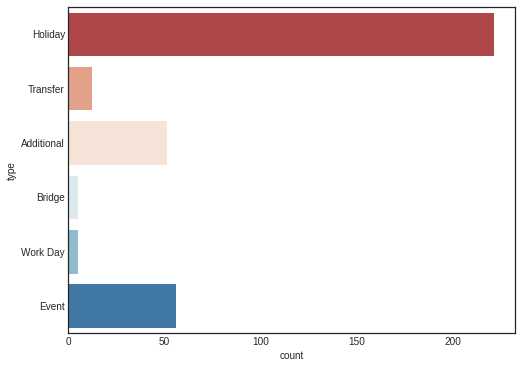

In [90]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax = sns.countplot( y="type", data=df_holiday, palette="RdBu")

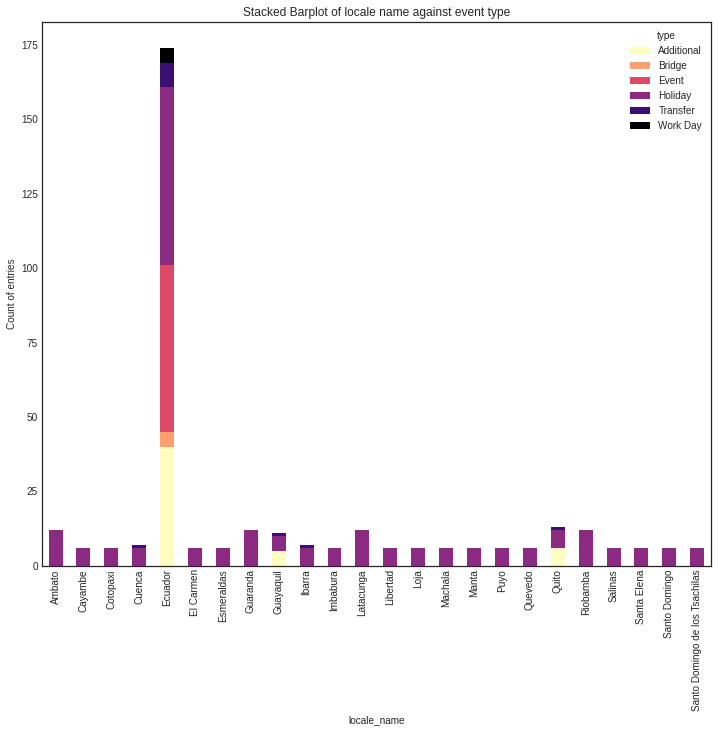

In [91]:
plt.style.use('seaborn-white')
holiday_local_type = df_holiday.groupby(['locale_name', 'type']).size()
holiday_local_type.unstack().plot(kind='bar',stacked=True, colormap= 'magma_r', figsize=(12,10),  grid=False)
plt.title('Stacked Barplot of locale name against event type')
plt.ylabel('Count of entries')
plt.show()